<a href="https://colab.research.google.com/github/eduvaladao/aulas_bigdata_astro_CBPF/blob/main/BayesianInference_Cosmology_SL_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary Python Packages:

In [1]:
import sys 
sys.path.append('../') 

!pip install emcee 

import emcee 
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy.optimize import minimize 
from scipy.optimize import curve_fit 

from astropy import constants as const 
from astropy import units as u 
from astropy.cosmology import FlatLambdaCDM 
from multiprocessing import Pool 

from IPython.display import display, Math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.4 MB/s 


# Defining the Cosmology:

In [2]:
# Cosmology used:
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089) 

# Physical constants:
print(const.c)
c = (const.c).to(u.km/u.second) 
clight = c.value 
print(clight)

  Name   = Speed of light in vacuum
  Value  = 299792458.0
  Uncertainty  = 0.0
  Unit  = m / s
  Reference = CODATA 2018
299792.458


# Functions of our Physical Model:

In [3]:
def ratio_gamma(y, x):
    """ Eq. (15) from arXiv:0907.4992v2
    Args:
        y (float): parameter
        x (float): parameter
    Returns:
        float: ratio of gamma funcions.
    """
    return sp.special.gamma(y/2)/sp.special.gamma(x/2)

In [4]:
def ratio_gammax(x):
    """ Eq. (15) from arXiv:0907.4992v2
    Args:
        x (float): parameter
    Returns:
        float: ratio of gamma funcions.
    """  
    return ratio_gamma(x - 1, x)

In [5]:
def vel(z_S, z_L, theta_E, seeing_atm, theta_ap, alpha, beta, delta, gamma):
    """ Eq. (23) from arXiv:0907.4992v2
    Args:
        z_S (float): source redshift
        z_L (float): lens redshift
        theta_E (float): Einstein radius (in radians)
        seeing_atm (float): Atmospheric seeing (in radians)
        theta_ap (float): Aperture size (in radians)
        alpha (float): power-law matter density profile index
        beta (float): anisotropy parameter
        delta (float): luminosity density profile index
        gamma (float): slip parameter
    Returns:
        float: analytic model for velocity dispersion given observational conditions.
    """

    # Angular diameter distances:
    DS = cosmo.angular_diameter_distance(z_S)
    DL = cosmo.angular_diameter_distance(z_L)
    DLS = cosmo.angular_diameter_distance_z1z2(z_L, z_S)

    # \chi
    chi = theta_ap/seeing_atm

    # tilde_sigma = seeing_atm^tilde
    tilde_sigma = seeing_atm*np.sqrt(1 + (chi**2)/4 + (chi**4)/40) 

    ksi = alpha + delta - 2

    term_1 = (2/(1 + gamma))*((clight**2)/4)*(DS/DLS)*theta_E
    term_2 = 2/(np.sqrt(np.pi)*(ksi - 2*beta))
    term_3 = (ratio_gammax(ksi) - beta*ratio_gammax(ksi + 2))/(ratio_gammax(alpha)*ratio_gammax(delta))
    term_4 = (2*((tilde_sigma/theta_E)**2))**(1 - alpha/2)
    term_5 = ratio_gamma(3 - ksi, 3 - delta)

    sigma_star = term_1*term_2*term_3*term_4*term_5

    return np.sqrt(np.abs(sigma_star))

# Necessary Functions for Maximum Likelihood Estimation and Maximum A Posterior:

In [6]:
def sum_log_gaussian(model, data, error):
    """ Natural Logarithm of a Gaussian 
    Args:
        model (float): mean value
        error (float): standard deviation
        data (float): data values
    Returns:
        float: Sum of log of Gaussians through all data.
    """
    return -0.5*np.sum(np.log(2*np.pi*(error**2)) + ((data - model)**2)/(error**2))

In [7]:
def log_prior(theta, alpha_0, eps_alpha_0, beta_0, eps_beta_0, delta_0, eps_delta_0):
    """ Gaussian priors
    Args:
        theta (list): list of parameters [alpha, beta, delta, gamma]
        alpha_0 (float): expected value for alpha
        eps_alpha_0 (float): variance of alpha
        beta_0 (float): expected value for beta
        eps_beta_0 (float): variance of beta
        delta_0 (float): expected value for delta
        eps_delta_0 (float): variance of delta
    Returns:
        float: Sum of log of priors for alpha, beta, and delta.
    """
    ''' we don't want to bias gamma in favor of any specific value because the goal is to measure it, 
    consequently we are going to consider a flat prior for it. '''
    alpha, beta, delta, gamma = theta
    n_sigma = 5
    if (alpha_0[0] - n_sigma*eps_alpha_0[0] < alpha < alpha_0[0] + n_sigma*eps_alpha_0[0]) and \
            (beta_0[0] - n_sigma*eps_beta_0[0] < beta < beta_0[0] + n_sigma*eps_beta_0[0]) and \
        (delta_0[0] - n_sigma*eps_delta_0[0] < delta < delta_0[0] + n_sigma*eps_delta_0[0]):
        log_prior_alpha = sum_log_gaussian(alpha_0, alpha, eps_alpha_0)
        log_prior_beta = sum_log_gaussian(beta_0, beta, eps_beta_0) 
        log_prior_delta = sum_log_gaussian(delta_0, delta, eps_delta_0)
        return log_prior_alpha + log_prior_beta + log_prior_delta
    else:
        return - np.inf

In [8]:
def log_likelihood(theta, z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap):
    """ log(Eq. (25)) from arXiv:0907.4992v2 
    Args:
        theta (list): list of parameters [alpha, beta, delta, gamma]
        z_S (float): source redshift
        z_L (float): lens redshift
        velDisp (float): velocity dispersion
        velDispErr (float): velocity dispersion error (std. dev.)
        theta_E (float): Einstein radius (in radians)
        seeing_atm (float): Atmospheric seeing (in radians)
        theta_ap (float): Aperture size (in radians)
    Returns:
        float: Loglikelihood function given the model for velocity dispersion and the one measured.
    """
    alpha, beta, delta, gamma = theta
    model = vel(z_S, z_L, theta_E, seeing_atm,
                theta_ap, alpha, beta, delta, gamma)
    loglikelihood = sum_log_gaussian(model, velDisp, velDispErr)
    return loglikelihood

In [9]:
def log_posterior(theta, z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap,
                    alpha_0, eps_alpha_0, beta_0, eps_beta_0, delta_0, eps_delta_0):
    """ Log of the posterior probability of interest
    Args:
        theta (list): list of parameters [alpha, beta, delta, gamma]
        z_S (float): source redshift
        z_L (float): lens redshift
        velDisp (float): velocity dispersion
        velDispErr (float): velocity dispersion error (std. dev.)
        theta_E (float): Einstein radius (in radians)
        seeing_atm (float): Atmospheric seeing (in radians)
        theta_ap (float): Aperture size (in radians)
        alpha_0 (float): expected value for alpha
        eps_alpha_0 (float): variance of alpha
        beta_0 (float): expected value for beta
        eps_beta_0 (float): variance of beta
        delta_0 (float): expected value for delta
        eps_delta_0 (float): variance of delta
    Returns:
        float: Eq. (27) from arXiv:0907.4992v2
    """
    lp = log_prior(theta, alpha_0, eps_alpha_0, beta_0,
                   eps_beta_0, delta_0, eps_delta_0)
    if not np.isfinite(lp):
        return - np.inf
    else:
        return lp + log_likelihood(theta, z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap)

In [10]:
def minimization_loglikelihood(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap,
                               seed=42, alpha_ini=2.0, beta_ini=0.18, delta_ini=2.4, gamma_ini=1.0):
    """ Maximization of Likelihood function
    Args:
        z_S (float): source redshift
        z_L (float): lens redshift
        velDisp (float): velocity dispersion
        velDispErr (float): velocity dispersion error (std. dev.)
        theta_E (float): Einstein radius (in radians)
        seeing_atm (float): Atmospheric seeing (in radians)
        theta_ap (float): Aperture size (in radians)
        seed (float): random seed for reproducibility purposes. Default: 42.
        alpha_ini (float, optional): Initial guess for alpha. Default: 2.0.
        beta_ini (float, optional): Initial guess for beta. Default: 0.18.
        delta_ini (float, optional): Initial guess for delta. Default: 2.4.
        gamma_ini (float, optional): Initial guess for gamma. Default: 1.0.
    Returns:
        list: list of alpha, beta, delta, and gamma obtained from minimization of -loglikelihood function.
    """
    np.random.seed(seed)
    nll = lambda *args: -log_likelihood(*args)

    initial = np.array([alpha_ini, beta_ini, delta_ini, gamma_ini]) + (1e-5)*np.random.randn(4)

    soln = minimize(nll, initial, args = (z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, )) 
    alpha_ml, beta_ml, delta_ml, gamma_ml = soln.x
    
    return float(alpha_ml), float(beta_ml), float(delta_ml), float(gamma_ml)

In [11]:
def minimization_logposterior(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap,
                                seed=42, alpha_ini=2.0, beta_ini=0.18, delta_ini=2.4, gamma_ini=1.0,
                                alpha_0_value=2.0, eps_alpha_0_value=0.08,
                                beta_0_value=0.18, eps_beta_0_value=0.13,
                                delta_0_value=2.4, eps_delta_0_value=0.11):
    """ Maximization of Log Posterior Probability function 
    Args:
        z_S (float): source redshift
        z_L (float): lens redshift
        velDisp (float): velocity dispersion
        velDispErr (float): velocity dispersion error (std. dev.)
        theta_E (float): Einstein radius (in radians)
        seeing_atm (float): Atmospheric seeing (in radians)
        theta_ap (float): Aperture size (in radians)
        seed (float): random seed for reproducibility purposes.
        alpha_ini (float, optional): Initial guess for alpha. Defaults to 2.0.
        beta_ini (float, optional): Initial guess for beta. Defaults to 0.18.
        delta_ini (float, optional): Initial guess for delta. Defaults to 2.4.
        gamma_ini (float, optional): Initial guess for gamma. Defaults to 1.0.
        alpha_0_value (float, optional): expected value for alpha. Defaults to 2.0.
        eps_alpha_0_value (float, optional): variance for alpha. Defaults to 0.08.
        beta_0_value (float, optional): expected value for beta. Defaults to 0.18.
        eps_beta_0_value (float, optional): variance for beta. Defaults to 0.13.
        delta_0_value (float, optional): expected value for delta. Defaults to 2.4.
        eps_delta_0_value (float, optional): variance for delta. Defaults to 0.11.
    Returns:
        list: list of alpha, beta, delta, and gamma obtained from minimization of -logposterior function.
    """
    alpha_0 = np.repeat(alpha_0_value, len(z_S)) 
    eps_alpha_0 = np.repeat(eps_alpha_0_value, len(z_S))

    beta_0 = np.repeat(beta_0_value, len(z_S))
    eps_beta_0 = np.repeat(eps_beta_0_value, len(z_S))

    delta_0 = np.repeat(delta_0_value, len(z_S))
    eps_delta_0 = np.repeat(eps_delta_0_value, len(z_S))

    np.random.seed(seed)
    nll_2 = lambda *args: -log_posterior(*args) 
    initial = np.array([alpha_ini, beta_ini, delta_ini, gamma_ini]) + 1e-5*np.random.randn(4) 
    
    soln_2 = minimize(nll_2, initial, args=(z_S, z_L, velDisp, velDispErr, theta_E,
                      seeing_atm, theta_ap, alpha_0, eps_alpha_0, beta_0, eps_beta_0, delta_0, eps_delta_0, )) 
    alpha_ml2, beta_ml2, delta_ml2, gamma_ml2 = soln_2.x 

    return float(alpha_ml2), float(beta_ml2), float(delta_ml2), float(gamma_ml2)

# Necessary Function for Bayesian Analysis:

In [12]:
def logposterior_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap,
                            seed=42, alpha_ini=2.0, beta_ini=0.18, delta_ini=2.4, gamma_ini=1.0,
                            alpha_0_value=2.0, eps_alpha_0_value=0.08,
                            beta_0_value=0.18, eps_beta_0_value=0.13,
                            delta_0_value=2.4, eps_delta_0_value=0.11,
                            n_dim=4, n_walkers=64, n_burn=500, n_steps=10000, progress=True, processes=1):
    """ Sampling logprobability posterior function with emcee
    Args:
        z_S (float): source redshift
        z_L (float): lens redshift
        velDisp (float): velocity dispersion
        velDispErr (float): velocity dispersion error (std. dev.)
        theta_E (float): Einstein radius (in radians)
        seeing_atm (float): Atmospheric seeing (in radians)
        theta_ap (float): Aperture size (in radians)
        seed (float): random seed for reproducibility purposes.
        alpha_ini (float, optional): Initial guess for alpha. Defaults to 2.0.
        beta_ini (float, optional): Initial guess for beta. Defaults to 0.18.
        delta_ini (float, optional): Initial guess for delta. Defaults to 2.4.
        gamma_ini (float, optional): Initial guess for gamma. Defaults to 1.0.
        alpha_0_value (float, optional): expected value for alpha. Defaults to 2.0.
        eps_alpha_0_value (float, optional): variance for alpha. Defaults to 0.08.
        beta_0_value (float, optional): expected value for beta. Defaults to 0.18.
        eps_beta_0_value (float, optional): variance for beta. Defaults to 0.13.
        delta_0_value (float, optional): expected value for delta. Defaults to 2.4.
        eps_delta_0_value (float, optional): variance for delta. Defaults to 0.11.
        n_dim (int, optional): number of parameters in the model (r and p). Defaults to 4.
        n_walkers (int, optional): number of MCMC walkers. Defaults to 64.
        n_burn (int, optional): "burn-in" period to let chains stabilize. Defaults to 500.
        n_steps (int, optional): number of MCMC steps to take after burn-in. Defaults to 10000.
        progress (bool, optional): Show progress bar. Defaults to True.
        processes (int, optional): Number of processes in parallel. Defaults to 1.
    """
    alpha_0 = np.repeat(alpha_0_value, len(z_S))
    eps_alpha_0 = np.repeat(eps_alpha_0_value, len(z_S)) 

    beta_0 = np.repeat(beta_0_value, len(z_S))
    eps_beta_0 = np.repeat(eps_beta_0_value, len(z_S))

    delta_0 = np.repeat(delta_0_value, len(z_S))
    eps_delta_0 = np.repeat(eps_delta_0_value, len(z_S))
    
    with Pool(processes=processes) as pool:
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=(z_S, z_L, velDisp, velDispErr, theta_E,
                                                                                 seeing_atm, theta_ap, alpha_0,
                                                                                 eps_alpha_0, beta_0, eps_beta_0, delta_0, eps_delta_0, ), pool=pool)
        np.random.seed(seed)
        solu = minimization_loglikelihood(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap,
                                          seed, alpha_ini, beta_ini, delta_ini, gamma_ini)
        p0 = solu + (1e-3)*np.random.randn(n_walkers, n_dim)

        # Run n_burn steps as a burn-in:
        print('Running burn-in ...')
        pos, prob, state = sampler.run_mcmc(p0, n_burn, progress=progress)

        # Reset the chain to remove the burn-in samples:
        sampler.reset()

        # Starting from the final position in the burn-in chain, sample for n_steps steps:
        print('Sampling ...')
        sampler.run_mcmc(pos, n_steps, rstate0=state, progress=progress)

    return sampler

In [13]:
def trace_plots(labels, samples, fig, axes, color, n_dim):
    """ Function that makes trace plots of the Markov chains
    Args:
        labels (list, strings): labels of the plots
        samples (list, floats): samples from the MCMC
        fig (plt function): matplotlib function to define figures
        axes (plt function): matplotlib function to define axes ticks etc
        color (string or whatever): if it's string, all the trace_plots will have color = color. 
        If it's not, then will have multiple colors (each color for each walker chain)
        n_dim (integer): dimensions of parameter space
    Returns:
        plt figure: a trace plot for each parameter.
    """
    bla = 'string'
    for i in range(n_dim):
        ax = axes[i]
        if type(color) == type(bla):
            ax.plot(samples[:, :, i], color, alpha=0.3) 
        else: 
            ax.plot(samples[:, :, i])
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i], fontsize=14)     
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number", fontsize=14);

# Mounting google drive and downloading strong lensing data:

In [14]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [15]:
df = pd.read_csv('/content/drive/MyDrive/sample103.csv') 
df2 = df.copy()  

# The column labels of the DataFrame:
df2.columns = ["id", "z<sub>lens</sub>", "z<sub>source</sub>", "\u03B8<sub>E</sub>", "\u03B8<sub>ap</sub>", 
              "\u03C3<sub>atm</sub>", "\u03C3<sub>SDSS</sub>","\u03B5<sub>SDSS</sub>"]
df2.iloc[0:20].style  

,id,zlens,zsource,θE,θap,σatm,σSDSS,εSDSS
0,J0151+0049,0.517000,1.364000,0.680000,1.000000,1.800000,219.000000,39.000000
1,J0747+4448,0.437000,0.897000,0.610000,1.000000,1.800000,281.000000,52.000000
2,J0830+5116,0.530000,1.332000,1.140000,1.000000,1.800000,268.000000,36.000000
3,J0944-0147,0.539000,1.179000,0.720000,1.000000,1.800000,204.000000,34.000000
4,J1215+0047,0.642000,1.297000,1.370000,1.000000,1.800000,262.000000,45.000000
5,J1337+3620,0.564000,1.182000,1.390000,1.000000,1.800000,225.000000,35.000000
6,J1542+1629,0.352000,1.023000,1.040000,1.000000,1.800000,210.000000,16.000000
7,J1545+2748,0.522000,1.289000,1.210000,1.000000,1.800000,250.000000,37.000000
8,J1601+2138,0.544000,1.446000,0.860000,1.000000,1.800000,207.000000,36.000000
9,J1631+1854,0.408000,1.086000,1.630000,1.000000,1.800000,272.000000,14.000000


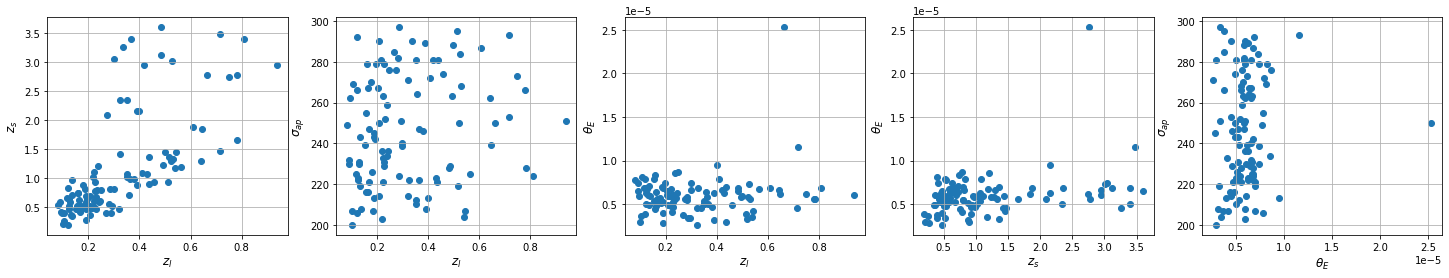

In [16]:
# About the data:
z_L = df['zl'].values 
z_S = df['zs'].values
theta_E = (df['theta_E'].values*u.arcsec).to(u.rad).value 
theta_ap = (df['theta_ap'].values*u.arcsec).to(u.rad).value
seeing_atm = (df['sigma_atm'].values*u.arcsec).to(u.rad).value
velDisp = df['sigma_ap'].values
velDispErr = df['d_sigma_ap'].values

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,4))

lista1 = [z_L, z_S, velDisp, theta_E, z_S, theta_E, velDisp]
lista2 = [r'$z_{l}$', r'$z_{s}$', r'$\sigma_{ap}$', r'$\theta_{E}$', r'$z_{s}$', r'$\theta_{E}$', r'$\sigma_{ap}$']
for i in range(6):
    if i + 1 < 4:
        axes[i].scatter(x = lista1[0], y = lista1[i+1]) 
        axes[i].set_xlabel(lista2[0], fontsize = 12)
        axes[i].set_ylabel(lista2[i+1], fontsize = 12)  
        axes[i].grid(True)
    elif i + 1 > 4:
        axes[i-1].scatter(x = lista1[i], y = lista1[i+1]) 
        axes[i-1].set_xlabel(lista2[i], fontsize = 12)
        axes[i-1].set_ylabel(lista2[i+1], fontsize = 12)
        axes[i-1].grid(True)

# Maximum Likelihood Estimation (MLE):

Frequentist approach, all priors are flat:

In [17]:
# About the parameters value and distribution:
mean_alpha = 2.0
var_alpha = 0.08
mean_beta = 0.18
var_beta = 0.13
mean_delta = 2.4
var_delta = 0.11

gamma = 1.0

X0 = minimization_loglikelihood(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, seed=42, alpha_ini=mean_alpha, beta_ini=mean_beta, delta_ini=mean_delta, gamma_ini=gamma)

In [18]:
print("The parameters that maximize the probability of observing the data given the model (the likelihood) are:\n")
print("\u03B1 = " + str(round(X0[0], 3)))
print("\u03B2 = " + str(round(X0[1], 3)))
print("\u03B4 = "+ str(round(X0[2], 3)))
print("\u03B3 = " + str(round(X0[3], 3)))

The parameters that maximize the probability of observing the data given the model (the likelihood) are:

α = 1.834
β = 0.165
δ = 2.484
γ = 0.651


# Maximum A Posterior (MAP):

Bayesian approach, updating our degree of belief in our physical model based on data (priors are updated to posteriors):

In [19]:
X_param = minimization_logposterior(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                                seed = 11, alpha_ini = mean_alpha, beta_ini = mean_beta, delta_ini= mean_delta, gamma_ini = gamma,  \
                                alpha_0_value = mean_alpha, eps_alpha_0_value = var_alpha, beta_0_value = mean_beta, eps_beta_0_value = var_beta,
                                                 delta_0_value=mean_delta, eps_delta_0_value=var_delta)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [20]:
print("The parameters that maximize the probability of our model happens given the data (the posterior, according to Bayes Theorem) are:\n")
print("\u03B1 = " + str(round(X_param[0], 3)))
print("\u03B2 = " + str(round(X_param[1], 3)))
print("\u03B4 = "+ str(round(X_param[2], 3)))
print("\u03B3 = " + str(round(X_param[3], 3)))

The parameters that maximize the probability of our model happens given the data (the posterior, according to Bayes Theorem) are:

α = 1.993
β = 0.18
δ = 2.4
γ = 1.029


# Markov Chain Monte Carlo (MCMC):

In [21]:
seed = 11
np.random.seed(seed)

n_dim = 4         # number of parameters in the model 
n_walkers = 10    # number of MCMC walkers (let's start with ten walkers)

# An ensemble MCMC sampler:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args = (z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                                                                                       np.repeat(mean_alpha, len(z_S)), np.repeat(var_alpha, len(z_S)),
                                                                                       np.repeat(mean_beta, len(z_S)), np.repeat(var_beta, len(z_S)), 
                                                                                       np.repeat(mean_delta, len(z_S)), np.repeat(var_delta, len(z_S))))

In [22]:
X0 = X0 + (1e-5)*np.random.randn(n_walkers, n_dim)

In [23]:
n_burn = 50       # "burn-in" period to let chains stabilize.

Xn, prob, state = sampler.run_mcmc(X0, n_burn, progress = True)

100%|██████████| 50/50 [00:00<00:00, 63.60it/s]


In [24]:
n_steps = 500    # number of MCMC steps to take after burn-in period.
sampler.reset()  

X, prob, state = sampler.run_mcmc(Xn, n_steps, rstate0 = state, progress = True)

100%|██████████| 500/500 [00:08<00:00, 59.73it/s]


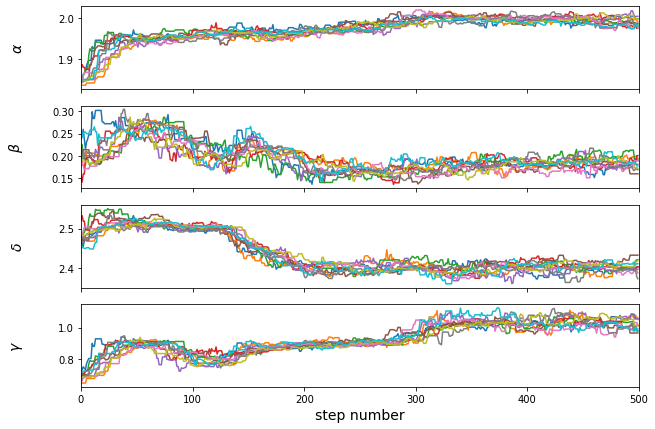

In [25]:
# Plotando as cadeias/correntes de Markov (Trace plots):
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()  

labels = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]

trace_plots(labels, samples, fig, axes, 0, n_dim)

In [26]:
n_dim = 4          # number of parameters in the model.
n_walkers = 100    # number of MCMC walkers.
n_burn = 500       # "burn-in" period to let chains stabilize.
n_steps = 5000     # number of MCMC steps to take after burn-in.

sampler = logposterior_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = seed, alpha_ini = mean_alpha, beta_ini = mean_beta, delta_ini = mean_delta, gamma_ini = gamma,  
                            alpha_0_value = mean_alpha, eps_alpha_0_value = var_alpha, beta_0_value = mean_beta, eps_beta_0_value = var_beta,
                            delta_0_value=mean_delta, eps_delta_0_value=var_delta,
                            n_dim = n_dim, n_walkers = n_walkers, n_burn = n_burn, n_steps = n_steps, progress = True, processes = 10)

Running burn-in ...


100%|██████████| 500/500 [01:25<00:00,  5.82it/s]


Sampling ...


100%|██████████| 5000/5000 [14:00<00:00,  5.95it/s]


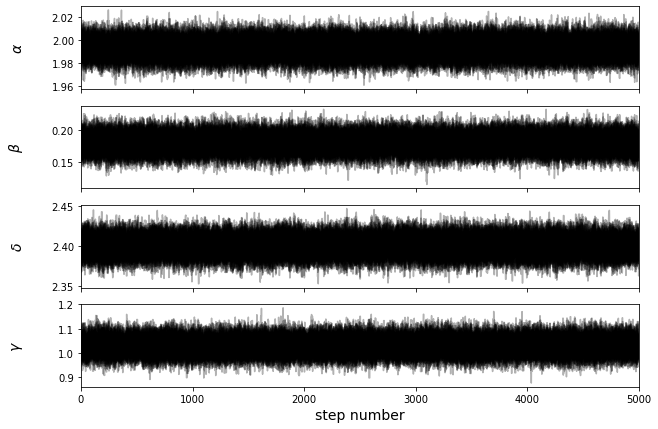

In [27]:
# Trace plots:
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]

trace_plots(labels, samples, fig, axes, "k", n_dim)

In [28]:
sampler.get_autocorr_time()

array([42.5999225 , 41.16397431, 41.80935619, 42.27833012])

# Plot of the multivariante distributions (posteriors):

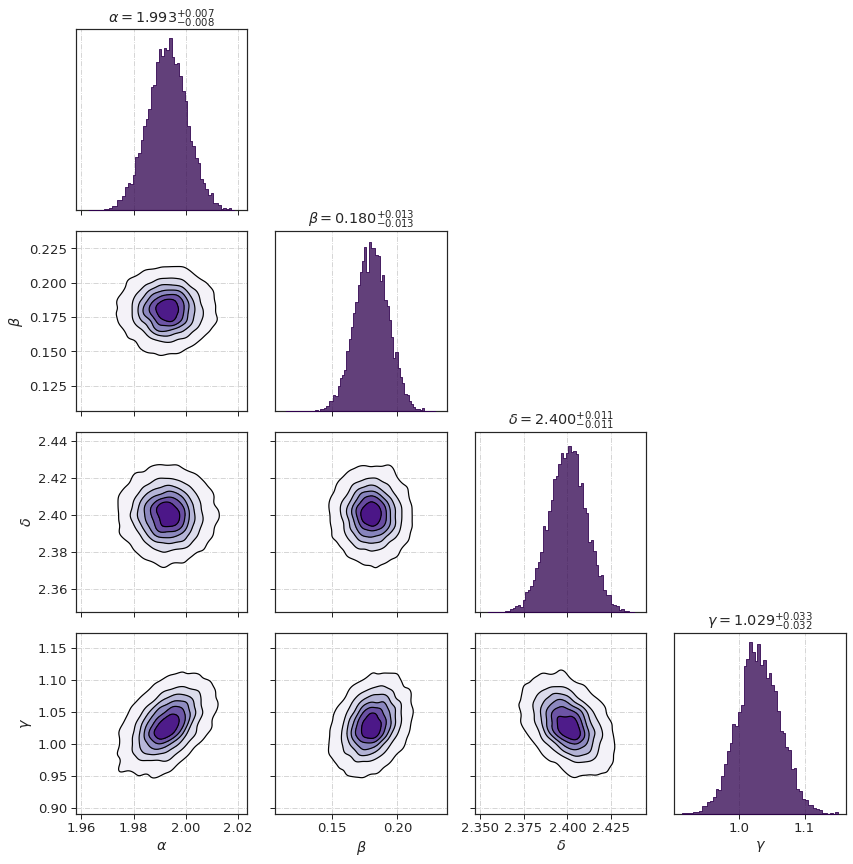

In [29]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)

sns.set_style("ticks", {'grid.color': '.8', 'grid.linestyle': '-.', 'axes.grid': True})
sns.set_context("paper", font_scale=1.5, rc={'axes.linewidth': 1.2})

g = sns.PairGrid(data = pd.DataFrame(flat_samples, columns = labels), corner = True, height = 3, despine=False)  
g = g.map_diag(sns.histplot, element="step", fill=True, color = "#2e004d") 
g = g.map_lower(sns.kdeplot, fill=True, levels=7, cmap = "Purples") 
g = g.map_lower(sns.kdeplot, levels=7, color = "Black")

for i in range(len(labels)): 
    percentile =  np.percentile(flat_samples[:, i], [15.85, 50, 84.15])
    diff = np.diff(percentile)
    l = labels[i][:-1] + " = {0:.3f}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(percentile[1], diff[1], diff[0])
    g.axes[i][i].set_title(l)
    g.savefig('/content/drive/MyDrive/cornerplot_bayes_cosmology2.pdf')

# Fitting a Gaussian posterior to gamma:

In [30]:
def gaussian(x, mean, amplitude, sigma):
    return amplitude*np.exp(-((x - mean)**2)/(2.0*(sigma**2)))

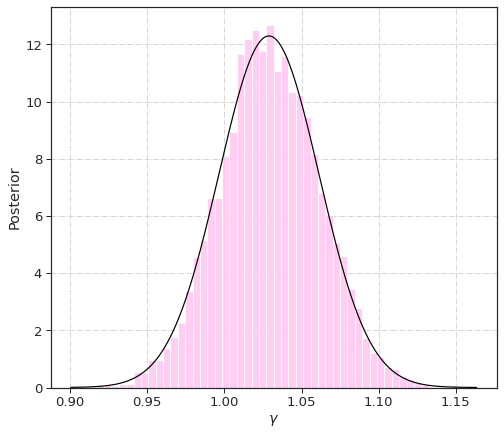

In [31]:
plt.figure(figsize= (8,7))
gamma = flat_samples[:, 3]
bins = 50
g = sns.histplot(gamma, bins=bins, alpha = .95, stat = "density", color = "#ffccf2") #f5e6ff
g.set_xlabel(r"$\gamma$")
g.set_ylabel(r"Posterior")

ax = g.get_children()
bin_height = []
bin_center = []
for i in range(bins):
    bin_height.append(ax[i].get_height())
    bin_center.append((ax[i].get_width()/2.0) + ax[i].get_x())

popt, pcov = curve_fit(gaussian, bin_center, bin_height, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(g.get_xlim()[0], g.get_xlim()[1], 10000)
sns.lineplot(x = x_interval_for_fit, y = gaussian(x_interval_for_fit, *popt), color = "Black")

In [32]:
print("This give us an estimation for an average value of \u03B3 an for its standard deviation:")

display(Math("\gamma_{PPN}" + " = {0:.3f}".format(popt[0])))
display(Math("\epsilon_{\gamma}" + "= {0:.3f}".format(abs(popt[2]))))

This give us an estimation for an average value of γ an for its standard deviation:


<IPython.core.display.Math object>

<IPython.core.display.Math object>